In [96]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import yfinance as yf
import datetime
from datetime import date, timedelta
import yahoo_fin.stock_info as si
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.metrics import mean_squared_error
# fix random seed for reproducibility
np.random.seed(7)
plt.style.use('fivethirtyeight')

In [97]:
today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=5000)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download('TSLA', 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
data["Date"] = data.index
data = data[["Open", "High", "Low", "Close", 
             "Adj Close", "Volume"]]
#data.reset_index(drop=True, inplace=True)
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-08,240.270004,245.270004,239.270004,243.839996,243.839996,102980100
2023-12-11,242.740005,243.440002,237.449997,239.740005,239.740005,97913900
2023-12-12,238.550003,238.990005,233.869995,237.009995,237.009995,95328300
2023-12-13,234.190002,240.300003,228.199997,239.289993,239.289993,146286300
2023-12-14,241.220001,253.880005,240.789993,251.050003,251.050003,160569000


In [98]:
data.shape

(3390, 6)

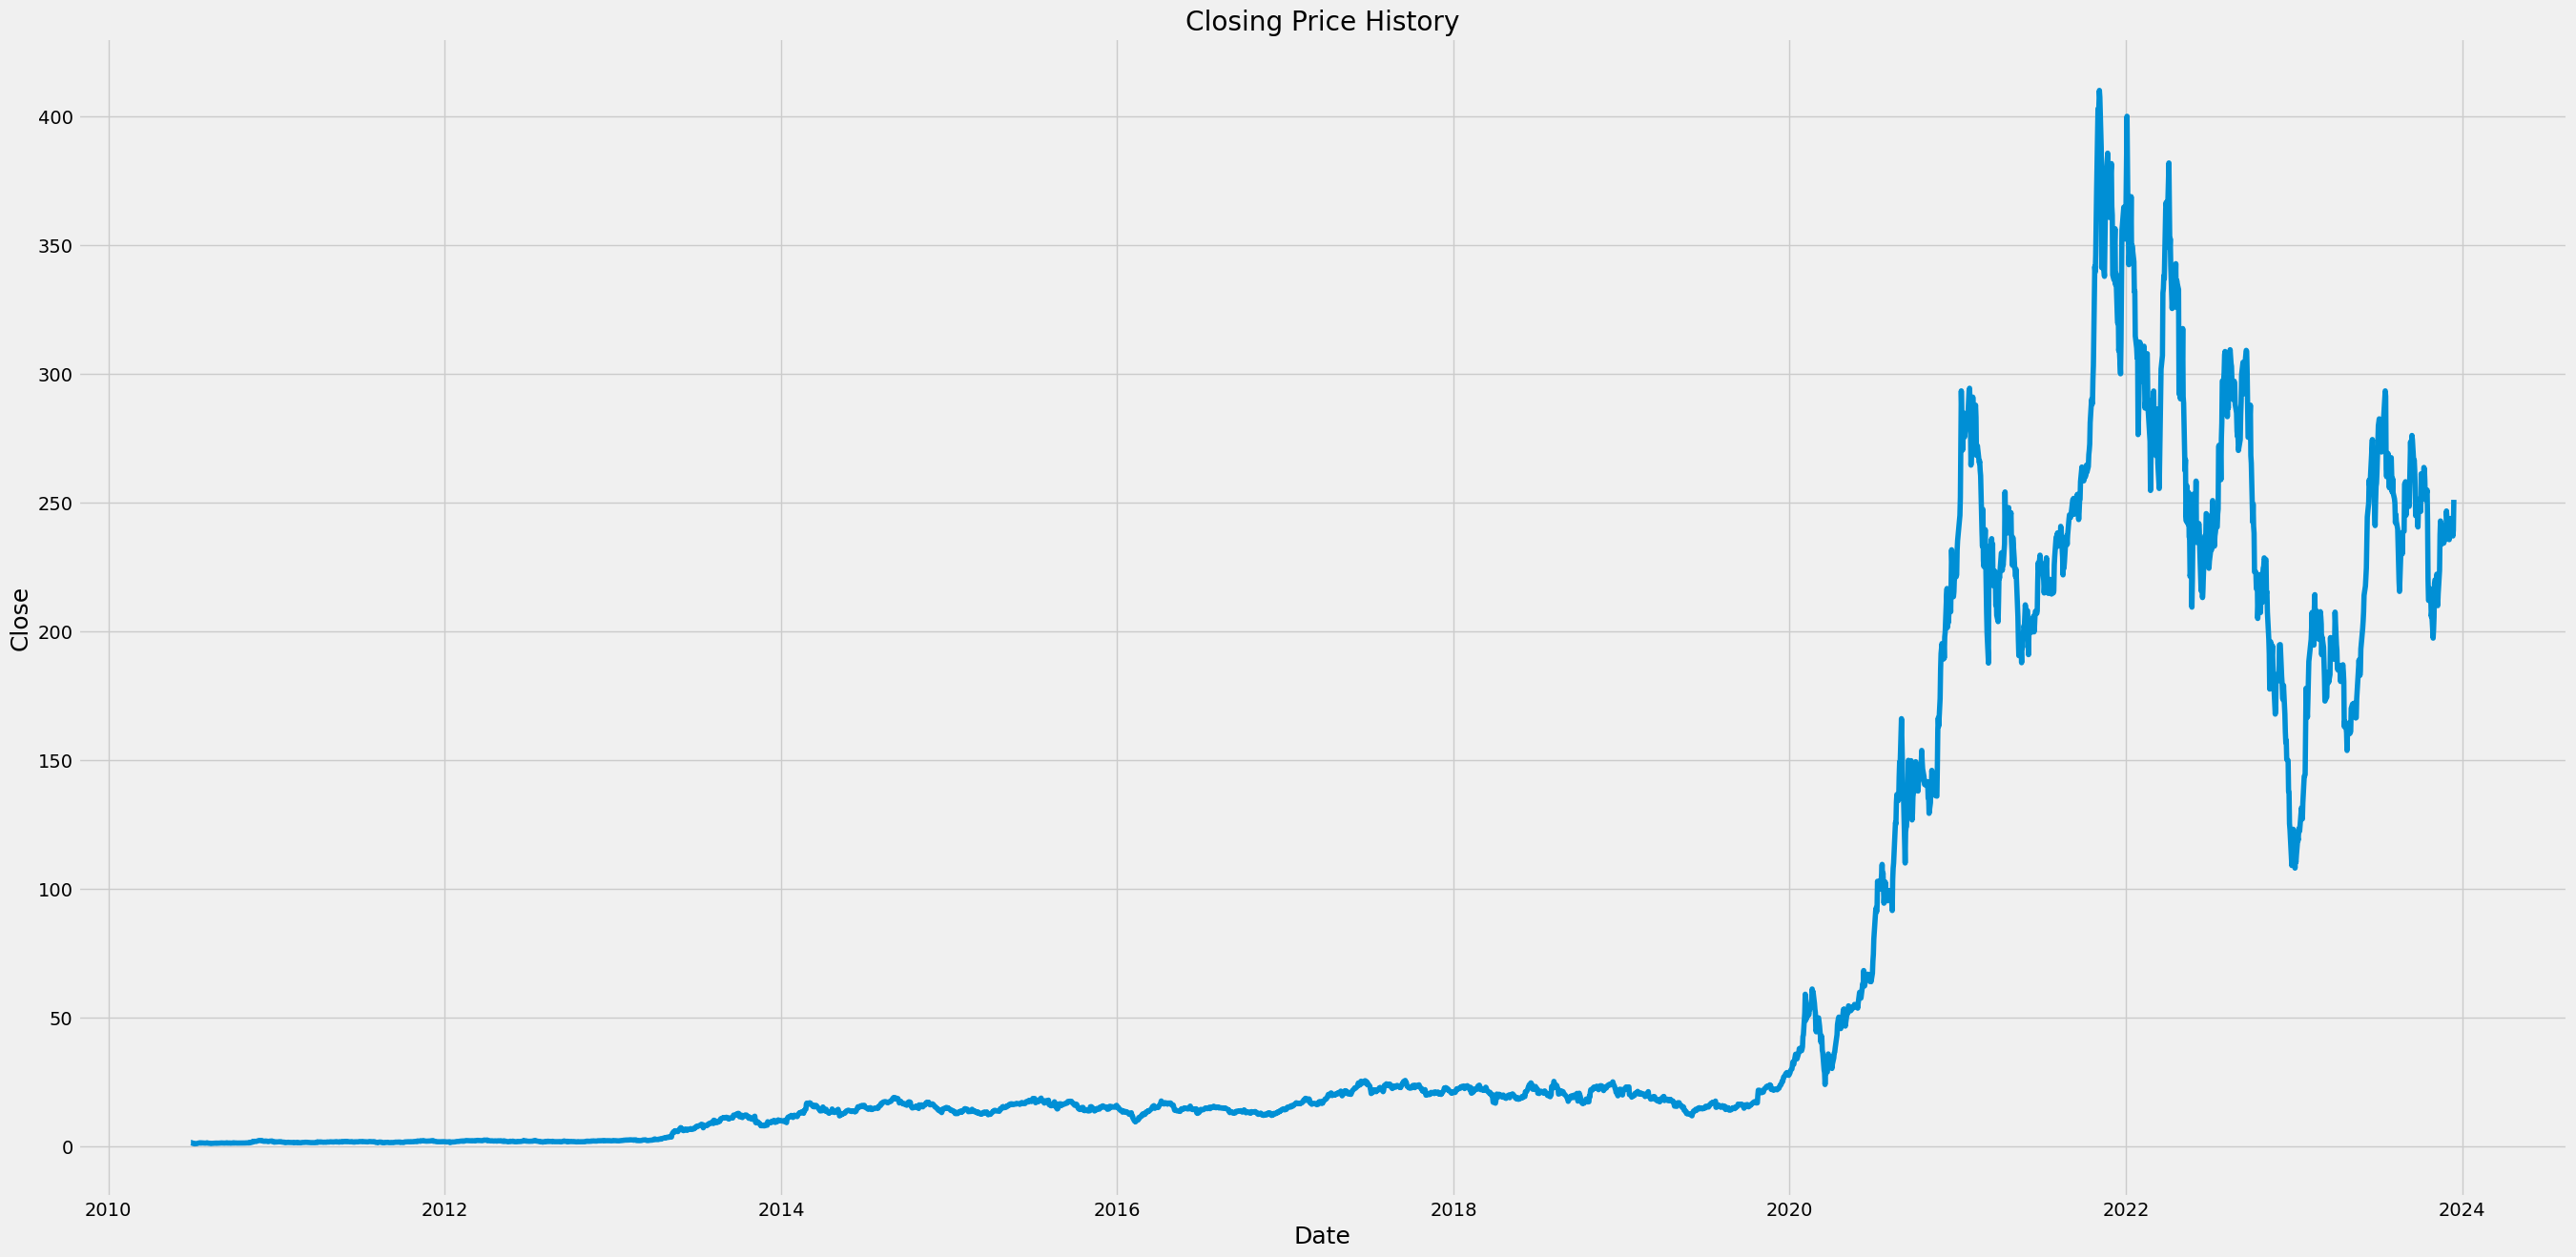

In [99]:
plt.figure(figsize=(30,15))
plt.title('Closing Price History')
plt.plot(data['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close', fontsize=18)
plt.show()

In [100]:
from statsmodels.tsa.stattools import adfuller
def ad_test(df):
    dftest = adfuller(df, autolag = 'AIC')
    print("1. ADF: ",dftest[0])
    print("2. P-Value", dftest[1])
    print("3. Num Of Lags:", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation", dftest[3])
    print("5. Critical Values:")
    for key, val in dftest[4].items():
        print("\t", key, ": ", val)

In [101]:
ad_test(data.Close)

1. ADF:  -0.8576669112318703
2. P-Value 0.8015935927919648
3. Num Of Lags: 29
4. Num Of Observations Used For ADF Regression and Critical Values Calculation 3360
5. Critical Values:
	 1% :  -3.432297709187285
	 5% :  -2.862400584424308
	 10% :  -2.567228105955924


In [102]:
ad_test(data.Close.diff().dropna())

1. ADF:  -11.082136936377697
2. P-Value 4.28496334485811e-20
3. Num Of Lags: 28
4. Num Of Observations Used For ADF Regression and Critical Values Calculation 3360
5. Critical Values:
	 1% :  -3.432297709187285
	 5% :  -2.862400584424308
	 10% :  -2.567228105955924


In [103]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [104]:
import pmdarima as pm

# Fit auto_arima for original data
model_original = pm.auto_arima(data['Close'], 
                                start_p=1, start_q=1,
                                test='adf',       # use adftest to find optimal 'd'
                                max_p=3, max_q=3,  # maximum p and q
                                m=1,               # frequency of series
                                d=None,            # let model determine 'd'
                                seasonal=False,    # No Seasonality
                                start_P=0, 
                                D=0, 
                                trace=True,
                                error_action='ignore',  
                                suppress_warnings=True, 
                                stepwise=True)

print(model_original.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20049.317, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20050.678, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20049.842, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20049.918, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20049.524, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=20051.136, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=20051.120, Time=0.86 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=20051.338, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=20051.225, Time=0.26 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=20053.230, Time=0.93 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=20048.198, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=20048.812, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=20048.736, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=20050.005, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0

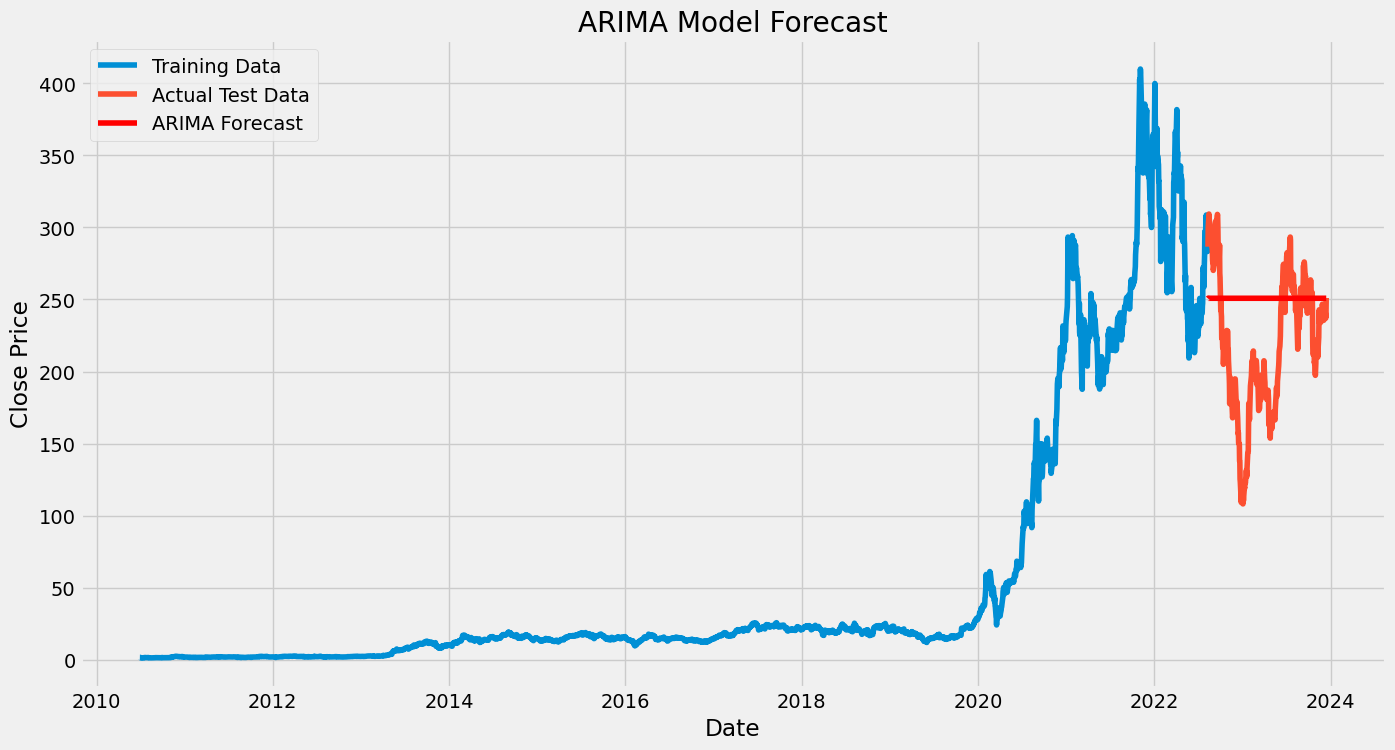

In [105]:
# Load necessary libraries
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA

# Set the order based on the best model
order = (1, 1, 1)

# Split the data into training and testing sets (90% training, 10% testing)
train_size = int(len(data) * 0.9)
train, test = data['Close'][:train_size], data['Close'][train_size:]

model = ARIMA(data['Close'], order=(1, 1, 1))
fitted_model = model.fit()

forecast_steps = len(test)
forecast = fitted_model.forecast(steps=forecast_steps)

plt.figure(figsize=(15, 8))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Test Data')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()


In [106]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(test_df['Close'], forecast)

print(f'Mean Absolute Error (MAE): {mae}')


Mean Absolute Error (MAE): 45.36286124718168


In [107]:
forecast.head()

3390    250.727484
3391    250.922193
3392    250.804645
3393    250.875610
3394    250.832767
Name: predicted_mean, dtype: float64

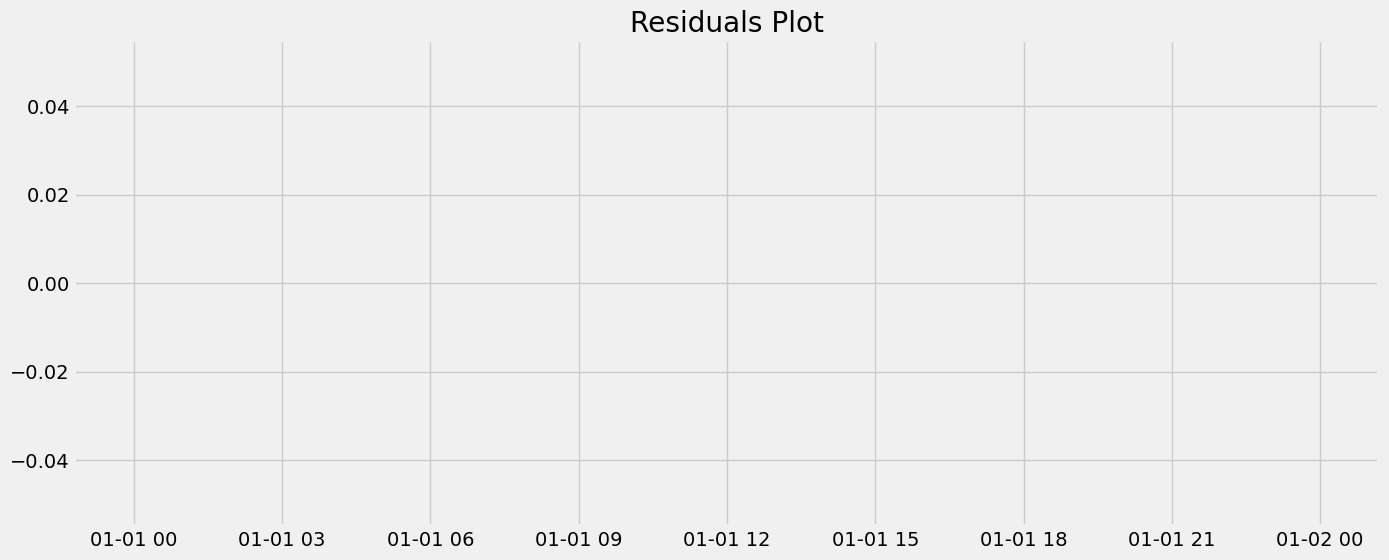

In [108]:
# Check residuals
residuals = test - forecast
plt.figure(figsize=(15, 6))
plt.plot(residuals)
plt.title('Residuals Plot')
plt.show()


Implies high Overfitting Next we will try Bidirectional LSTM